In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import seaborn.objects as so
import re
from itertools import product


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet


sns.set(style = 'darkgrid')
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 100
plt.rcParams["figure.figsize"] = (15,7)
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('Desktop/Books/projects/adease forecasting/train_1.csv')
exog = pd.read_csv('Desktop/Books/projects/adease forecasting/Exog_Campaign_eng')

In [5]:
raw_data = data.copy(deep=True)

In [6]:
data.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-22,2015-08-23,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-29,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-12,2015-09-13,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-19,2015-09-20,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-26,2015-09-27,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-03,2015-10-04,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-10,2015-10-11,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-17,2015-10-18,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31,2015-11-01,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-14,2015-11-15,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-21,2015-11-22,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-28,2015-11-29,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-05,2015-12-06,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-12,2015-12-13,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-19,2015-12-20,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,2016-04-25,2016-04-26,2016-04-27,2016-04-28,2016-04-29,2016-04-30,2016-05-01,2016-05-02,2016-05-03,2016-05-04,2016-05-05,2016-05-06,2016-05-07,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,2016-06-16,2016-06-17,2016-06-18,2016-06-19,2016-06-20,2016-06-21,2016-06-22,2016-06-23,2016-06-24,2016-06-25,2016-06-26,2016-06-27,2

In [7]:
data.shape

(145063, 551)

**We have 145063 different pages and visits for 550 days**

### Missing values check

In [8]:
#Checking the count of nulls in each column. 
data.isnull().sum()

Page              0
2015-07-01    20740
2015-07-02    20816
2015-07-03    20544
2015-07-04    20654
              ...  
2016-12-27     3701
2016-12-28     3822
2016-12-29     3826
2016-12-30     3635
2016-12-31     3465
Length: 551, dtype: int64

**Clearly we have lots of nulls in each column**

In [9]:
data.loc[data['Page']=='52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider']
d1 = datetime.strptime('2015-07-01', "%Y-%m-%d")
print('Start date:', d1)

d2 = datetime.strptime('2016-04-16', "%Y-%m-%d")
print('End time:',d2)

# get difference
delta = d2 - d1

# time difference in seconds
print(f"Days difference is {delta} seconds")

Start date: 2015-07-01 00:00:00
End time: 2016-04-16 00:00:00
Days difference is 290 days, 0:00:00 seconds


- We also have pages where the data hasn't started before a certain date. So We have to remove those records once we have reshaped the data.

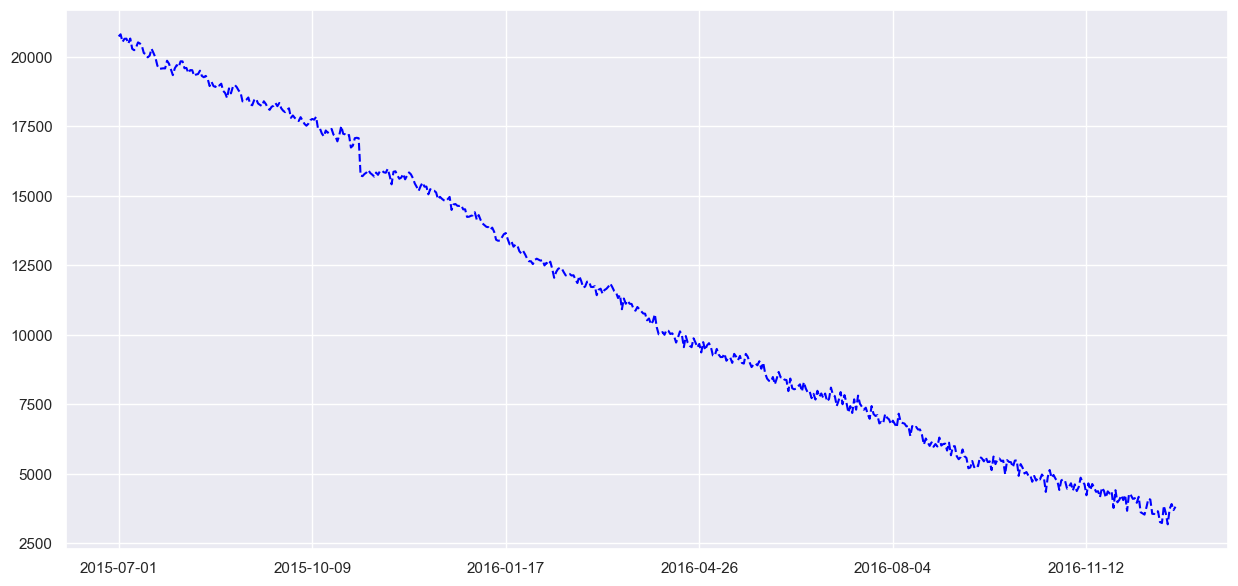

In [10]:
data.iloc[:, 1:-3 ].isnull().sum().plot(color='blue', linestyle='dashed')
plt.show()

- The chart above illustrates a decreasing trend in NaN/Null values over time. Recent dates exhibit fewer Null Values compared to earlier dates.

- This phenomenon is plausible because pages created or hosted at later dates naturally lack data for previous dates (dates preceding their creation/hosting).

- To address this, we plan to eliminate rows containing more than 300 Null Values and substitute the remaining Null Values with 0.

In [11]:
data.dropna(thresh = 300, inplace = True)
print(f'Shape of Data : {data.shape}')

Shape of Data : (133617, 551)


In [12]:
data.fillna(0, inplace = True)

### Feature Extraction

In [13]:
#Function to Extract Language from Page using Regex
def get_language(name):
    if len(re.findall(r'_(.{2}).wikipedia.org_', name)) == 1 : 
        return re.findall(r'_(.{2}).wikipedia.org_', name)[0]
    else: return 'Unknown_language'

data['language'] = data['Page'].apply(get_language)


language_dict ={'de':'German',
                'en':'English', 
                'es': 'Spanish', 
                'fr': 'French', 
                'ja': 'Japenese' , 
                'ru': 'Russian', 
                'zh': 'Chinese',
                'Unknown_language': 'Unknown_language'}

data['language'] = data['language'].map(language_dict)

In [14]:
def get_access_type(name):
    if len(re.findall(r'all-access|mobile-web|desktop', name)) == 1 : 
        return re.findall(r'all-access|mobile-web|desktop', name)[0]
    else: return 'No Access_type'

data['access_type'] = data['Page'].apply(get_access_type)

In [15]:
def get_access_origin(name):
    if len(re.findall(r'[ai].org_(.*)_(.*)$', name)) == 1 : 
        return re.findall(r'[ai].org_(.*)_(.*)$', name)[0][1]
    else: return 'No Access_origin'
    
data['access_origin'] = data['Page'].apply(get_access_origin)

#### Plotting count of langauges

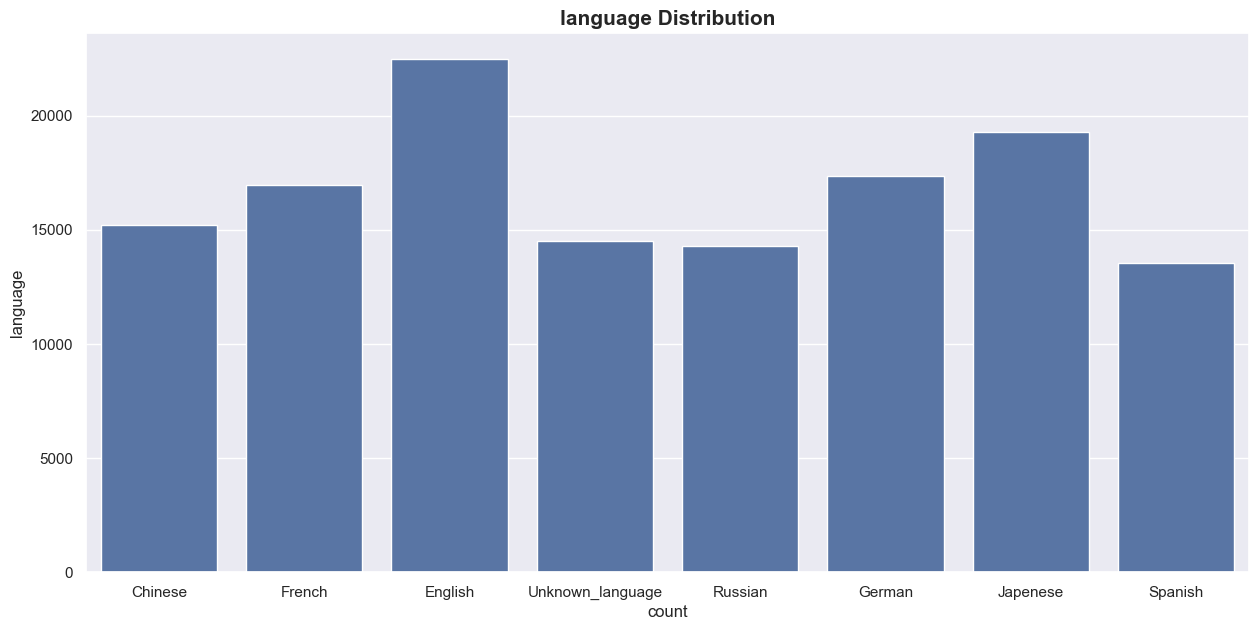

In [16]:
# plt.figure(figsize=(15, 7))
sns.countplot(x='language' , data=data)
plt.title('language Distribution')
plt.xlabel('count')
plt.ylabel('language')
plt.title('language Distribution', fontsize = 15, fontweight = 'bold')
plt.show()

#### Plotting access type

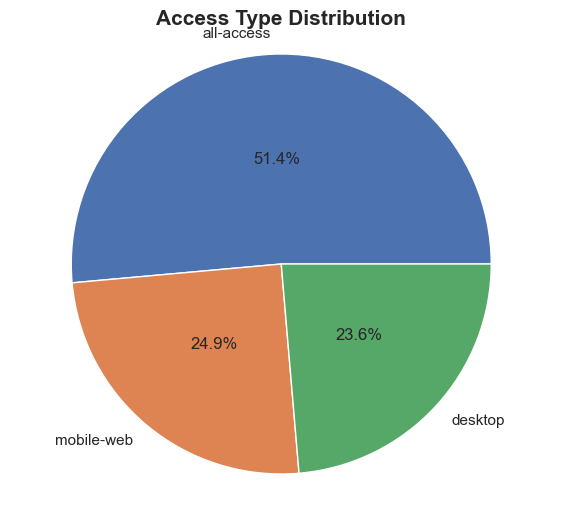

In [17]:
x = data['access_type'].value_counts().values
y = data['access_type'].value_counts().index

plt.figure(figsize=(7, 6))
plt.pie(x, labels = y, center=(0, 0), radius=1.5,  autopct='%1.1f%%', pctdistance=0.5)
plt.title('Access Type Distribution', fontsize = 15, fontweight = 'bold')
plt.axis('equal')
plt.show()

#### Plotting access orgin spread

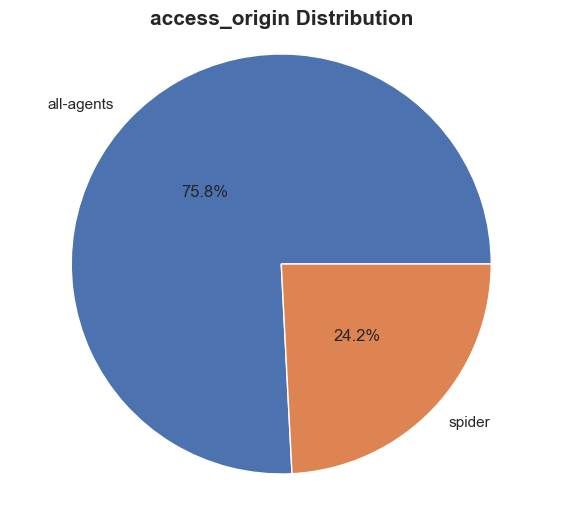

In [18]:
var = 'access_origin'
x = data[var].value_counts().values
y = data[var].value_counts().index

plt.figure(figsize=(7, 6))
plt.pie(x, labels = y, center=(0, 0), radius=1.5,  autopct='%1.1f%%', pctdistance=0.5)
plt.title(f'{var} Distribution', fontsize = 15, fontweight = 'bold')
plt.axis('equal')
plt.show()

### Reshaping data

In [19]:
reshaped = data.melt(id_vars = ['Page','language','access_type','access_origin'])

reshaped.sort_values(['Page', 'variable'],inplace=True)

In [20]:
reshaped.head()

,Page,language,access_type,access_origin,variable,value
0,2NE1_zh.wikipedia.org_all-access_spider,Chinese,all-access,spider,2015-07-01,18.0
1,2PM_zh.wikipedia.org_all-access_spider,Chinese,all-access,spider,2015-07-01,11.0
2,3C_zh.wikipedia.org_all-access_spider,Chinese,all-access,spider,2015-07-01,1.0
3,4minute_zh.wikipedia.org_all-access_spider,Chinese,all-access,spider,2015-07-01,35.0
4,5566_zh.wikipedia.org_all-access_spider,Chinese,all-access,spider,2015-07-01,12.0


In [21]:
reshaped.columns = ['Page','language','access_type', 'access_origin','Date', 'Visits']

In [22]:
reshaped.Date = pd.to_datetime(reshaped.Date, format ='%Y-%m-%d') 

In [23]:
lang_data = reshaped.groupby(['language', 'Date'],as_index=False)['Visits'].sum()

In [24]:
lang_data.shape

(4400, 3)

In [25]:
lang_data.head()

,language,Date,Visits
0,Chinese,2015-07-01,4144975.0
1,Chinese,2015-07-02,4151185.0
2,Chinese,2015-07-03,4123659.0
3,Chinese,2015-07-04,4163439.0
4,Chinese,2015-07-05,4441273.0


<Axes: xlabel='Date', ylabel='Visits'>

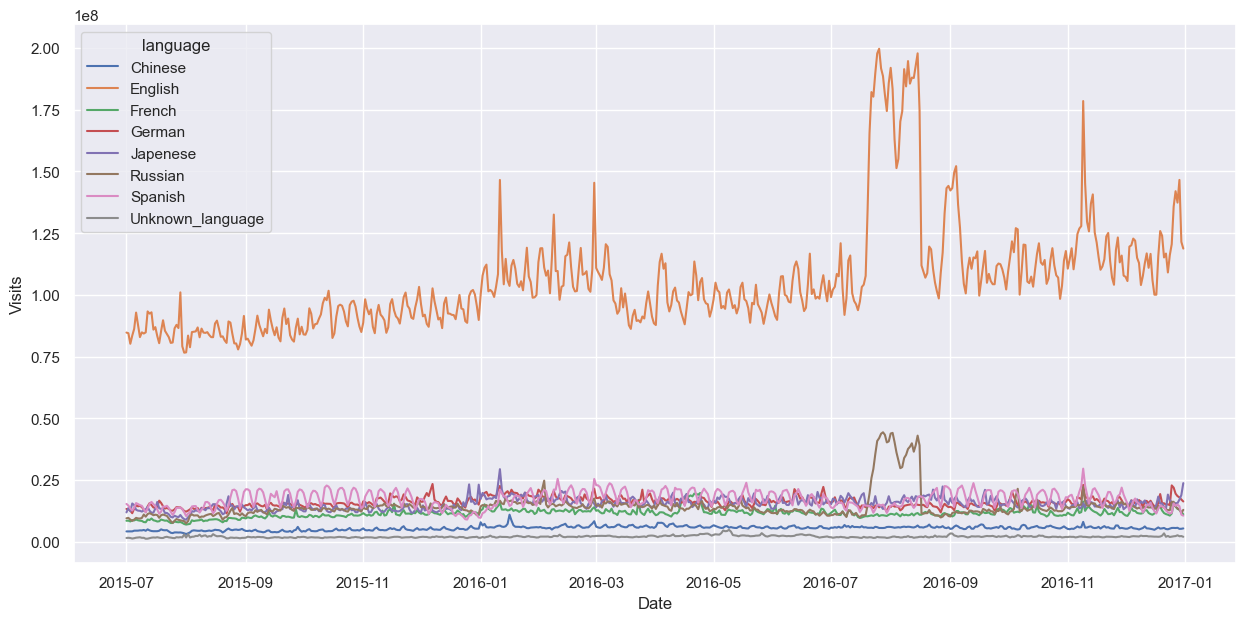

In [26]:
sns.lineplot(data=lang_data, y ='Visits',x='Date', hue='language')

In [27]:
lang_data.head()

,language,Date,Visits
0,Chinese,2015-07-01,4144975.0
1,Chinese,2015-07-02,4151185.0
2,Chinese,2015-07-03,4123659.0
3,Chinese,2015-07-04,4163439.0
4,Chinese,2015-07-05,4441273.0



### Checking Stationarity using ADF (Augmented Dickey Fuller) Test

In [28]:

#define function for ADF test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
       df_output['Critical Value (%s)' %key] = round(value,2)
    print (df_output)

In [29]:
adf_test(lang_data[lang_data['language'] == 'English']['Visits'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.373563
p-value                          0.149337
#Lags Used                      14.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.440000
Critical Value (5%)             -2.870000
Critical Value (10%)            -2.570000
dtype: float64


>The test statistic > critical value / p_value > 5%.
This implies that the series is not stationary.

### Decomposing Time Series

## Time Series Decomposition

Time series decomposition is a statistical technique used to break down a time series into its constituent components in order to understand its underlying structure, trends, seasonality, and irregular fluctuations. The decomposition typically involves separating the time series data into three main components:

1. **Trend (\(T_t\)):** The long-term movement or pattern in the data, representing the overall direction in which the time series is moving.
2. **Seasonality (\(S_t\)):** The repeating patterns or fluctuations that occur at regular intervals within the time series data.
3. **Residuals (\(R_t\)):** The remaining variation in the data after removing the trend and seasonality components.

The time series \(y_t\) can be decomposed into its components as follows:

- **Additive Decomposition:**
  \[ y_t = T_t + S_t + R_t \]

- **Multiplicative Decomposition:**
  \[ y_t = T_t \times S_t \times R_t \]

Various techniques such as moving averages, exponential smoothing, or mathematical models can be used to estimate the trend and seasonal components, leaving the residual component as the leftover variation in the data.



In [30]:
ts_english = lang_data[lang_data['language'] == 'English']['Visits']

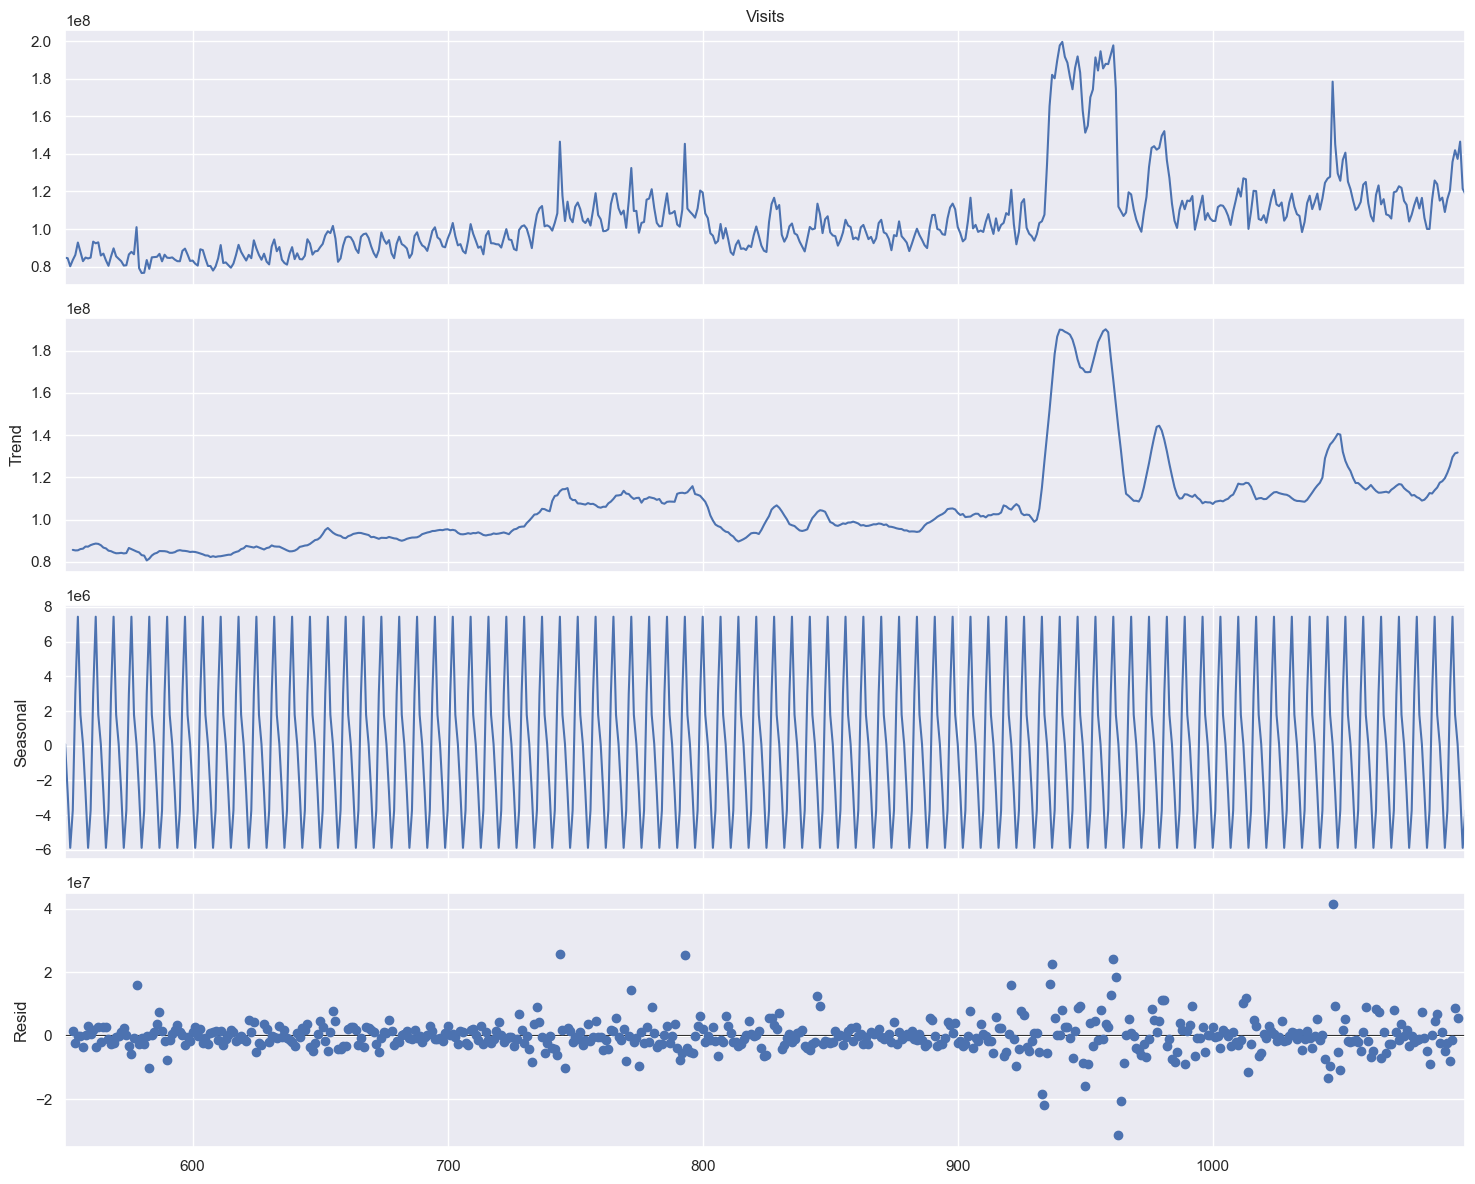

In [31]:

decomposition = seasonal_decompose(ts_english, model='additive', period=7)

fig = decomposition.plot()
fig.set_size_inches((15, 12))
fig.tight_layout()
plt.show()

In [32]:
residual = pd.DataFrame(decomposition.resid.fillna(0).values)
adf_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.152195e+01
p-value                        4.020092e-21
#Lags Used                     1.700000e+01
Number of Observations Used    5.320000e+02
Critical Value (1%)           -3.440000e+00
Critical Value (5%)           -2.870000e+00
Critical Value (10%)          -2.570000e+00
dtype: float64


> Residuals from time-series decomposition are now Stationary

### Estimating (p,q,d) & Interpreting ACF and PACF plots

In [33]:
ts_diff = pd.DataFrame(ts_english).diff(1)
ts_diff.dropna(inplace = True)

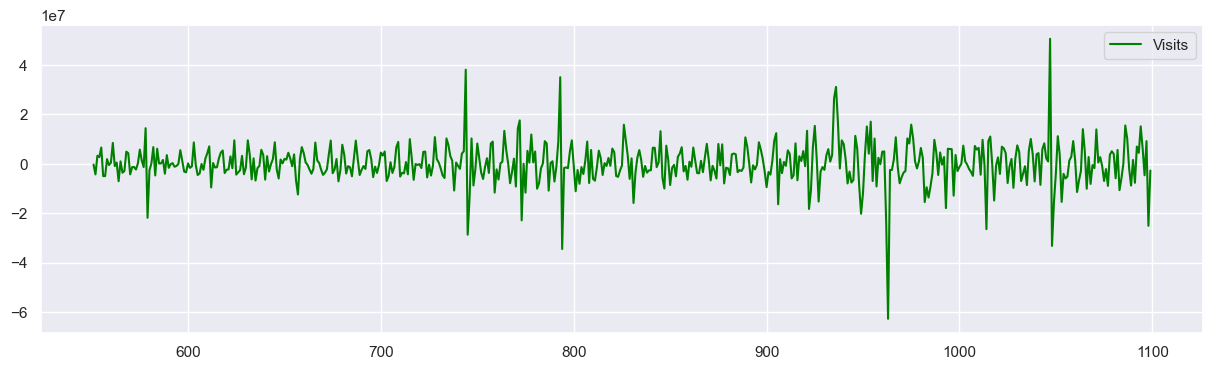

In [34]:
ts_diff.plot(color = 'green', figsize=(15, 4))
plt.show()

In [35]:
adf_test(ts_diff)

Results of Dickey-Fuller Test:
Test Statistic                -8.273590e+00
p-value                        4.721272e-13
#Lags Used                     1.300000e+01
Number of Observations Used    5.350000e+02
Critical Value (1%)           -3.440000e+00
Critical Value (5%)           -2.870000e+00
Critical Value (10%)          -2.570000e+00
dtype: float64


> We are getting a stationary time series after a differentiation of 1. d can therefore be 1. 

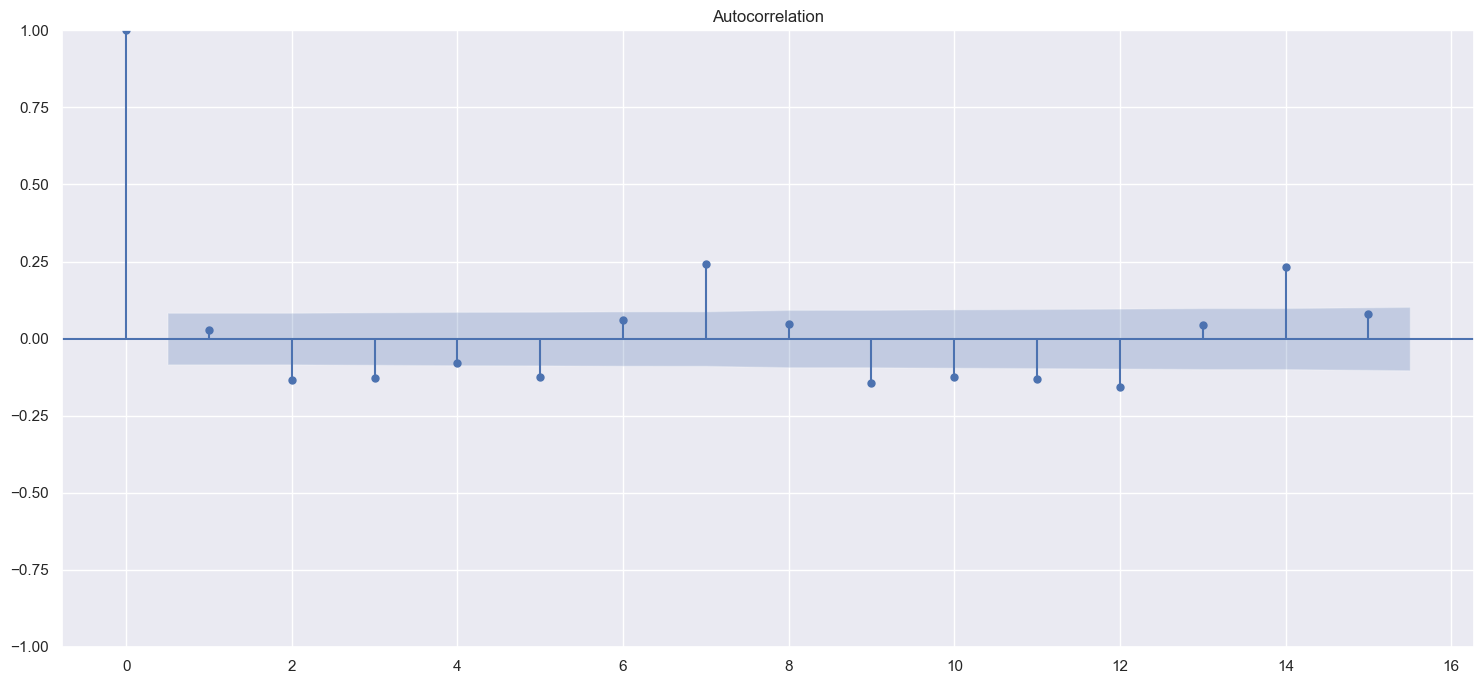

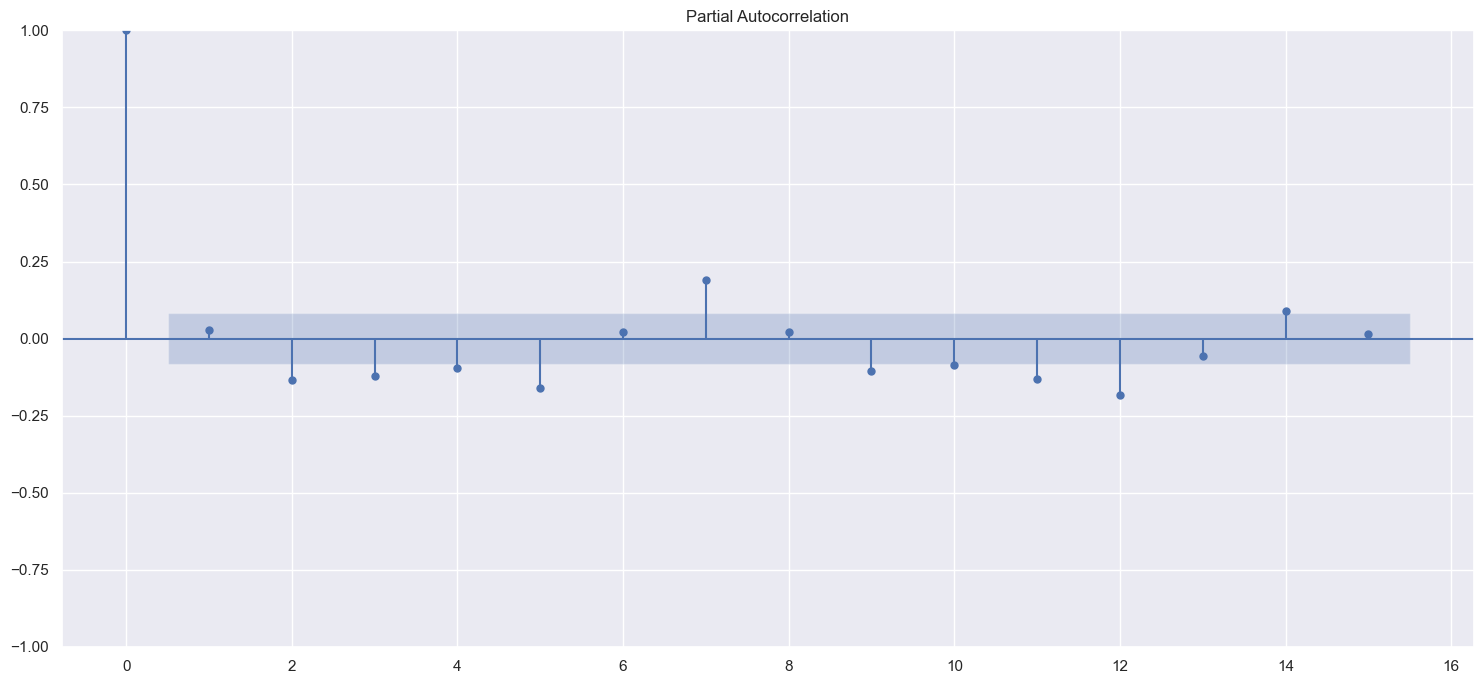

In [36]:
acf = plot_acf(ts_diff, lags= 15)
acf.tight_layout()
pacf = plot_pacf(ts_diff, lags= 15)
pacf.tight_layout()

##### ACF
- If the ACF shows a sharp cutoff after lag 'k', it suggests that an AR(k) model may be appropriate.
- If the ACF decreases gradually, it suggests a non-stationary series, and differencing (d) may be needed.
- If the ACF has a sinusoidal pattern or fluctuates around zero, it suggests a seasonal component.

> The ACF shows a sharp cutoff after lag 0, it suggests that an AR(0) model may be appropriate.

##### PACF
- If the PACF has a sharp cutoff after lag 'k', it suggests an MA(k) model may be appropriate.
- If the PACF gradually decreases, it suggests an AR component.
- If there are significant spikes at seasonal lags, it suggests a seasonal AR or MA component.

> The PACF has a sharp cutoff after lag 0, it suggests an MA(0) model may be appropriate.

In [37]:
ts_english = lang_data[lang_data.language == 'English'][['Date', 'Visits']]
ts_english.set_index('Date', drop=True, inplace=True)

In [38]:
def arima_model(n, order, time_series):
    model = ARIMA(time_series[:-n], order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=n, alpha=0.05)
    time_series.index = pd.to_datetime(time_series.index)
    forecast.index = pd.to_datetime(forecast.index)
    time_series[-60:].plot(label='Actual')
    forecast.plot(label='Forecast', linestyle='dashed', marker='o', markerfacecolor='green', markersize=2)
    plt.legend(loc="upper right")
    plt.title(f'ARIMA BASE Model {order}: Actual vs Forecasts', fontsize=15, fontweight='bold')
    plt.show()


    actuals = time_series.values[-n:]
    errors = time_series.values[-n:] - forecast.values
    
    mape = np.mean(np.abs(errors) / np.abs(actuals))
    rmse = np.sqrt(np.mean(errors**2))
    
    # Print MAPE & RMSE
    print('-' * 80)
    print(f'MAPE of Model: {np.round(mape, 5)}')
    print('-' * 80)
    print(f'RMSE of Model: {np.round(rmse, 3)}')
    print('-' * 80)

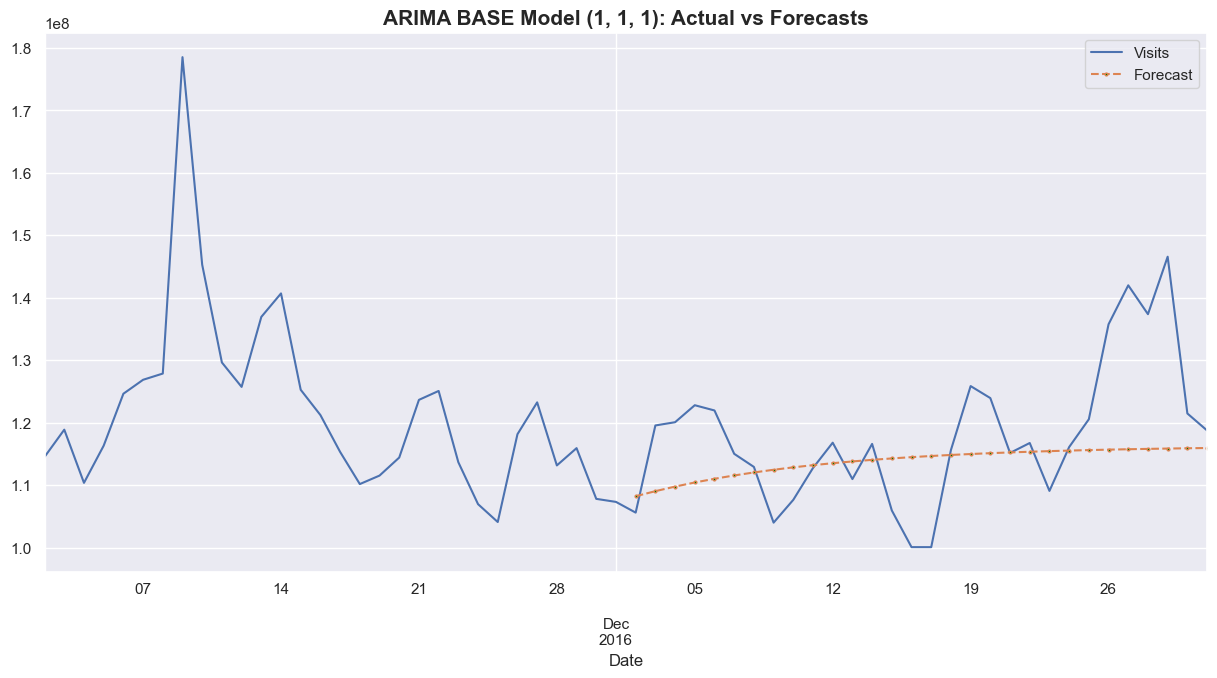

--------------------------------------------------------------------------------
MAPE of Model: 0.07229
--------------------------------------------------------------------------------
RMSE of Model: 12071775.511
--------------------------------------------------------------------------------


In [39]:
arima_model(30, (1,1,1), ts_english)

In [40]:
def sarimax_model(time_series, n, p=0, d=0, q=0, P=0, D=0, Q=0, s=0, exog = []):
    
    #Creating SARIMAX Model with order(p,d,q) & seasonal_order=(P, D, Q, s) 
    model = SARIMAX(time_series[:-n],
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, s),
                    exog=exog[:-n],
                    initialization='approximate_diffuse')
    model_fit = model.fit()
    
    # Forecasting last n-values
    model_forecast = model_fit.forecast(n, dynamic=True, exog=pd.DataFrame(exog[-n:]))
    
    # Plotting Actual & Forecasted values
    plt.figure(figsize=(20, 8))
    time_series[-60:].plot(label='Actual')
    model_forecast[-60:].plot(label='Forecast', color='red',
                              linestyle='dashed', marker='o', markerfacecolor='green', markersize=5)
    plt.legend(loc="upper right")
    plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts', fontsize=15, fontweight='bold')
    plt.show()
    
    # Calculating MAPE & RMSE
    actuals = time_series.values[-n:]
    errors = time_series.values[-n:] - model_forecast.values
    
    mape = np.mean(np.abs(errors) / np.abs(actuals))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    # Printing metrics
    print('-' * 80)
    print(f'MAPE of Model : {np.round(mape, 5)}')
    print('-' * 80)
    print(f'RMSE of Model : {np.round(rmse, 3)}')
    print('-' * 80)


In [41]:
exog = exog['Exog'].to_numpy()

<Figure size 2000x800 with 0 Axes>

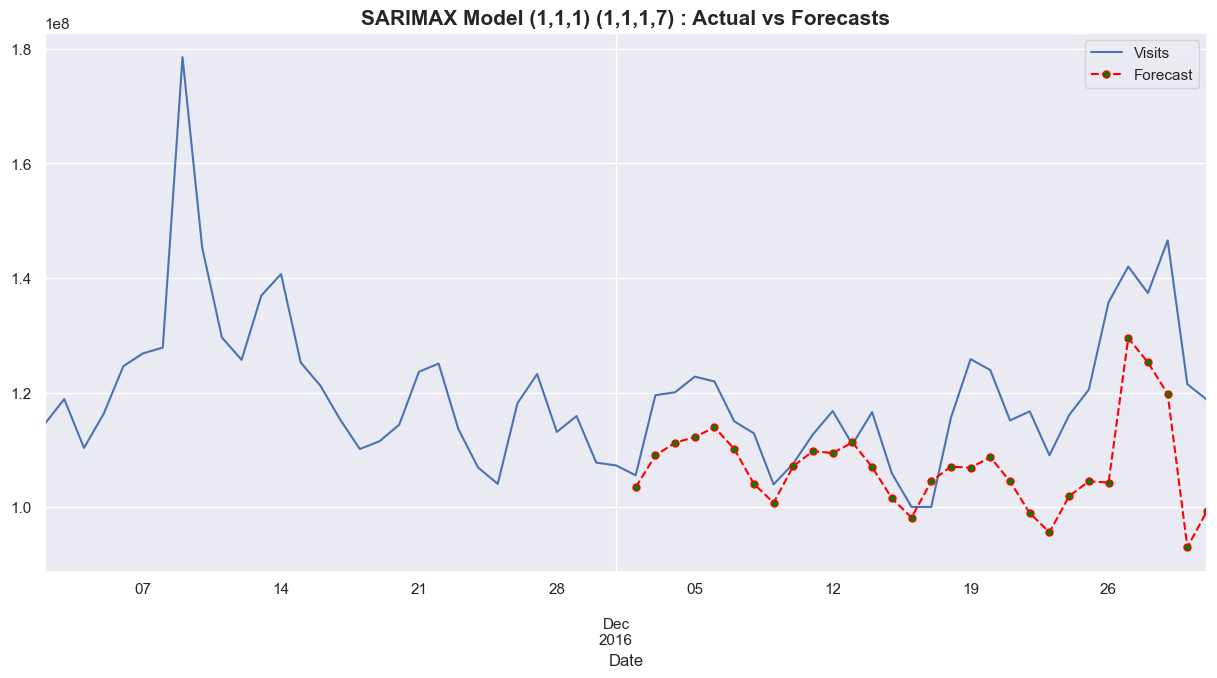

--------------------------------------------------------------------------------
MAPE of Model : 0.11208
--------------------------------------------------------------------------------
RMSE of Model : 17326667.279
--------------------------------------------------------------------------------


In [42]:
time_series = ts_english
test_size= 0.1
p,d,q, P,D,Q,s = 1,1,1,1,1,1,7
n = 30
sarimax_model(time_series, n, p = p, d=d,q=q,  P=P, D=D, Q=Q, s=s, exog = exog)

> Sarimax algorithm is giving us less than 12 % MAPE. 

### Grid Search 

In [43]:
def sarimax_grid_search(time_series, n, param, d_param, s_param, exog=[]):
    # Creating df for storing results summary
    param_df = pd.DataFrame(columns=['serial', 'pdq', 'PDQs', 'mape', 'rmse'])
    
    # Generate all parameter combinations
    param_combinations = product(param, d_param, param, param, d_param, param, s_param)
    
    # Counter for keeping track of iterations
    counter = 0
    
    for p, d, q, P, D, Q, s in param_combinations:
        model = SARIMAX(time_series[:-n], 
                        order=(p, d, q), 
                        seasonal_order=(P, D, Q, s), 
                        exog=exog[:-n],
                        initialization='approximate_diffuse')
        model_fit = model.fit()
        
        model_forecast = model_fit.forecast(n, dynamic=True, exog=pd.DataFrame(exog[-n:]))
        
        actuals = time_series.values[-n:]
        errors = time_series.values[-n:] - model_forecast.values
        
        mape = np.mean(np.abs(errors) / np.abs(actuals))
        rmse = np.sqrt(np.mean(errors**2))
        mape = np.round(mape, 5)
        rmse = np.round(rmse, 3)
        
        counter += 1
        list_row = [counter, (p, d, q), (P, D, Q, s), mape, rmse]
        param_df.loc[len(param_df)] = list_row
        
        # Print statement to check progress of Loop                
        print(f'Possible Combination: {counter} out of {len(param)**4 * len(s_param) * len(d_param)**2} calculated')
    
    return param_df


In [ ]:
time_series = ts_english
n = 30 
param = [0,1,2]
d_param = [0,1]
s_param = [7]

english_params  = sarimax_grid_search(time_series, n, param, d_param,s_param,exog)

In [45]:
english_params.sort_values(['mape', 'rmse']).head()

,serial,pdq,PDQs,mape,rmse
288,289,"(2, 1, 1)","(0, 0, 0, 7)",0.08737,1.390974e+07
289,290,"(2, 1, 1)","(0, 0, 1, 7)",0.08903,1.411103e+07
290,291,"(2, 1, 1)","(0, 0, 2, 7)",0.08988,1.421080e+07
294,295,"(2, 1, 1)","(1, 0, 0, 7)",0.09013,1.423713e+07
300,301,"(2, 1, 1)","(2, 0, 0, 7)",0.09273,1.456823e+07


<Figure size 2000x800 with 0 Axes>

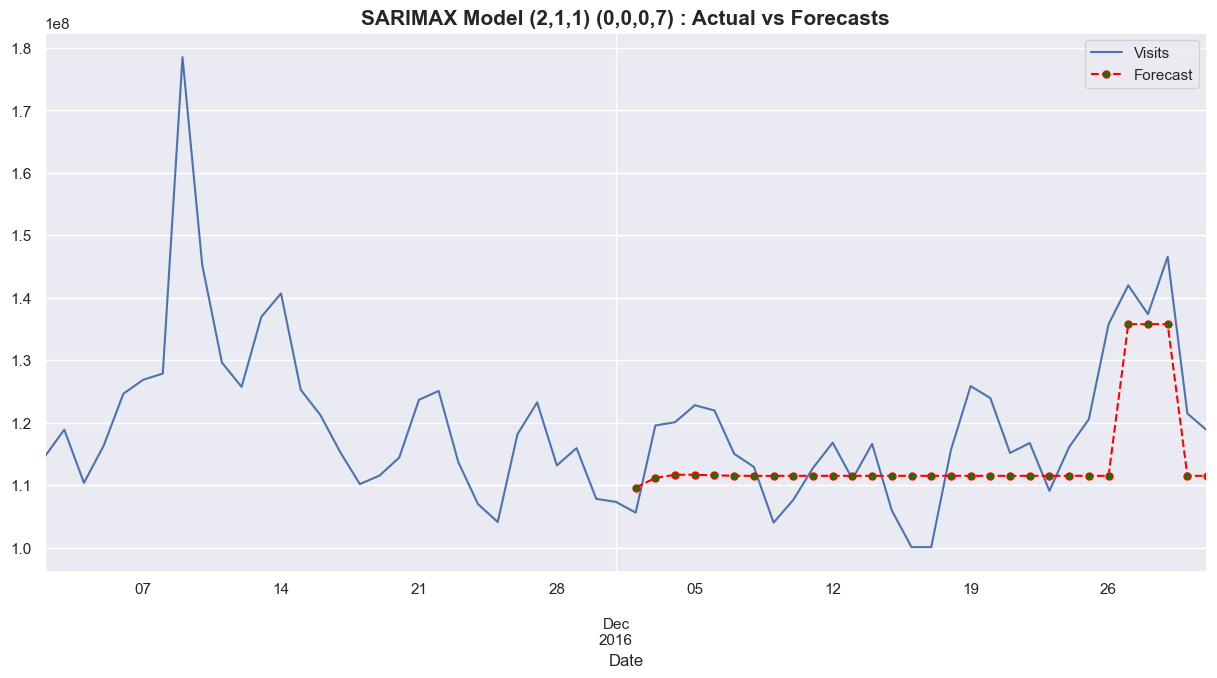

--------------------------------------------------------------------------------
MAPE of Model : 0.08737
--------------------------------------------------------------------------------
RMSE of Model : 13909735.545
--------------------------------------------------------------------------------


In [46]:
time_series = ts_english
p,d,q, P,D,Q,s = 2,1,1, 0,0,0,7
n = 30
sarimax_model(time_series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog = exog)

<Figure size 2000x800 with 0 Axes>

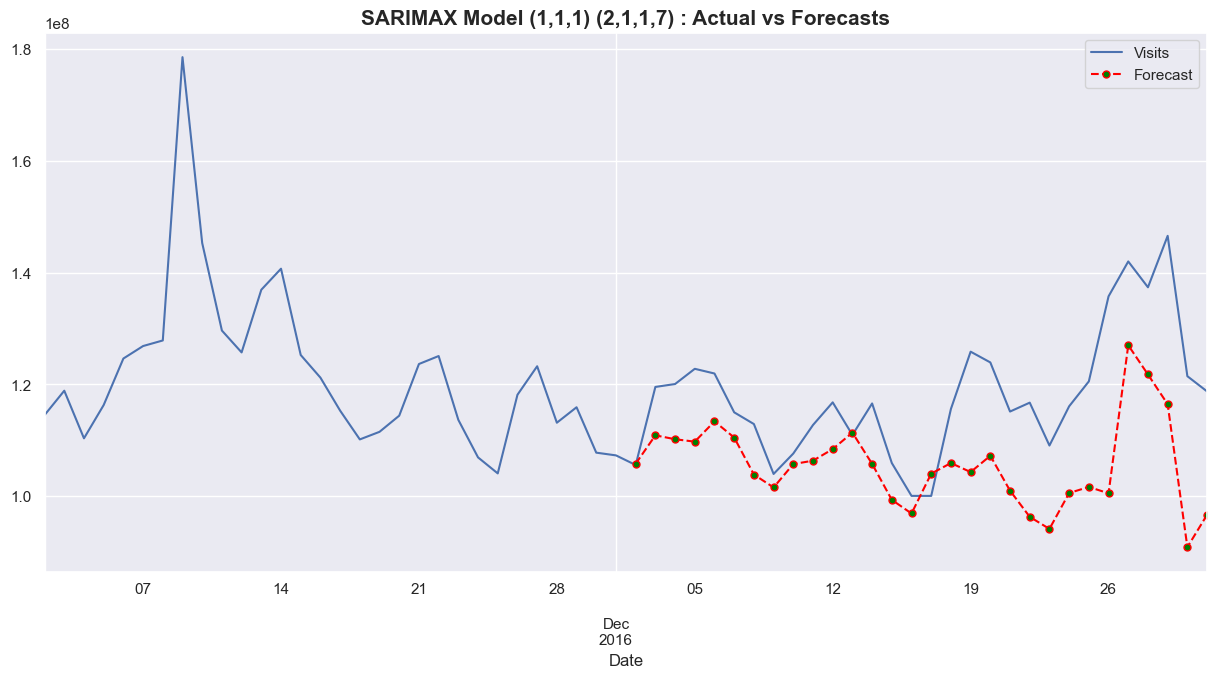

--------------------------------------------------------------------------------
MAPE of Model : 0.11871
--------------------------------------------------------------------------------
RMSE of Model : 18268474.479
--------------------------------------------------------------------------------


In [47]:
time_series = ts_english
p,d,q, P,D,Q,s = 1,1,1, 2,1,1,7
n = 30
sarimax_model(time_series, n, p=p, d=d, q=q, P=P, D=D, Q=Q, s=s, exog = exog)

In [48]:
def pipeline_sarimax_grid_search_without_exog(languages, data_language, n, param, d_param, s_param):
    
    best_param_df = pd.DataFrame(columns=['language', 'p', 'd', 'q', 'P', 'D', 'Q', 's', 'mape'])
    
    for lang in languages:
        print(f'--------------------------------------------------------------')
        print(f'          Finding best parameters for {lang}                  ')
        print(f'--------------------------------------------------------------')
        
        time_series = data_language[data_language['language'] == lang][['Date', 'Visits']]
        time_series.set_index('Date', drop=True, inplace=True)
        best_mape = 100
        
        counter = 0
        param_combinations = product(param, d_param, param, param, d_param, param, s_param)
        
        for p, d, q, P, D, Q, s in param_combinations:
            model = SARIMAX(time_series[:-n], 
                            order=(p, d, q), 
                            seasonal_order=(P, D, Q, s), 
                            initialization='approximate_diffuse')
            model_fit = model.fit()
            model_forecast = model_fit.forecast(n, dynamic=True)
            
            actuals = time_series.values[-n:]
            errors = time_series.values[-n:] - model_forecast.values
            mape = np.mean(np.abs(errors) / np.abs(actuals))
            
            counter += 1
            if mape < best_mape:
                best_mape = mape
                best_p, best_d, best_q = p, d, q
                best_P, best_D, best_Q = P, D, Q
                best_s = s
            
            print(f'Possible Combination: {counter} out of {(len(param)**4)*len(s_param)*(len(d_param)**2)} calculated')

        best_mape = np.round(best_mape, 5)
        print(f'--------------------------------------------------------------')
        print(f'Minimum MAPE for {lang} = {best_mape}')
        print(f'Corresponding Best Parameters are {best_p, best_d, best_q, best_P, best_D, best_Q, best_s}')
        print(f'--------------------------------------------------------------')
        
        best_param_row = [lang, best_p, best_d, best_q, best_P, best_D, best_Q, best_s, best_mape]
        best_param_df.loc[len(best_param_df)] = best_param_row                
                           
    return best_param_df


In [ ]:
languages = ['Chinese', 'French', 'German', 'Japenese', 'Russian', 'Spanish']
n = 30 
param = [0,1,2]
d_param = [0,1]
s_param = [7]


best_param_df = pipeline_sarimax_grid_search_without_exog(languages, lang_data, n, param, d_param, s_param)

In [50]:
best_param_df.sort_values(['mape'], inplace = True)
best_param_df

,language,p,d,q,P,D,Q,s,mape
0,Chinese,2,1,0,0,0,0,7,0.03932
4,Russian,0,0,1,2,0,0,7,0.06795
1,French,0,1,2,0,0,0,7,0.08091
2,German,2,0,1,0,0,0,7,0.08384
3,Japenese,1,1,2,0,0,1,7,0.09340
5,Spanish,2,0,0,0,0,1,7,0.14351


In [51]:
def plot_best_SARIMAX_model(languages, data_language, n, best_param_df):
    for lang in languages:
        # Fetching respective best parameters for that language
        params_lang = best_param_df[best_param_df['language'] == lang].iloc[0]
        p, d, q, P, D, Q, s = params_lang[['p', 'd', 'q', 'P', 'D', 'Q', 's']]

        # Creating language time-series
        time_series = data_language[data_language['language'] == lang][['Date', 'Visits']]
        time_series.set_index('Date', drop=True, inplace=True)
        
        # Creating SARIMAX Model
        model = SARIMAX(time_series[:-n], order=(p, d, q),
                        seasonal_order=(P, D, Q, s), initialization='approximate_diffuse')
        model_fit = model.fit()

        # Creating forecast for last n-values
        model_forecast = model_fit.forecast(n, dynamic=True)

        # Calculating MAPE & RMSE
        actuals = time_series.values[-n:]
        errors = time_series.values[-n:] - model_forecast.values
        mape = np.mean(np.abs(errors) / np.abs(actuals))
        rmse = np.sqrt(np.mean(errors**2))

        # Printing model statistics
        print(f'\n{"-" * 90}')
        print(f'SARIMAX model for {lang} Time Series')
        print(f'Parameters of Model: ({p}, {d}, {q}) ({P}, {D}, {Q}, {s})')
        print(f'MAPE of Model: {np.round(mape, 5)}')
        print(f'RMSE of Model: {np.round(rmse, 3)}')
        print(f'{"-" * 90}')

        # Plotting Actual & Forecasted values
        time_series.index = time_series.index.astype('datetime64[ns]')
        model_forecast.index = model_forecast.index.astype('datetime64[ns]')
        plt.figure(figsize=(20, 8))
        time_series[-60:].plot(label='Actual')
        model_forecast[-60:].plot(label='Forecast', color='red',
                                  linestyle='dashed', marker='o', markerfacecolor='green', markersize=5)
        plt.legend(loc="upper right")
        plt.title(f'SARIMAX Model ({p}, {d}, {q}) ({P}, {D}, {Q}, {s}): Actual vs Forecasts',
                  fontsize=15, fontweight='bold')
        plt.show()

    return 0



------------------------------------------------------------------------------------------
SARIMAX model for Chinese Time Series
Parameters of Model: (2, 1, 0) (0, 0, 0, 7)
MAPE of Model: 0.03932
RMSE of Model: 289943.436
------------------------------------------------------------------------------------------


<Figure size 2000x800 with 0 Axes>

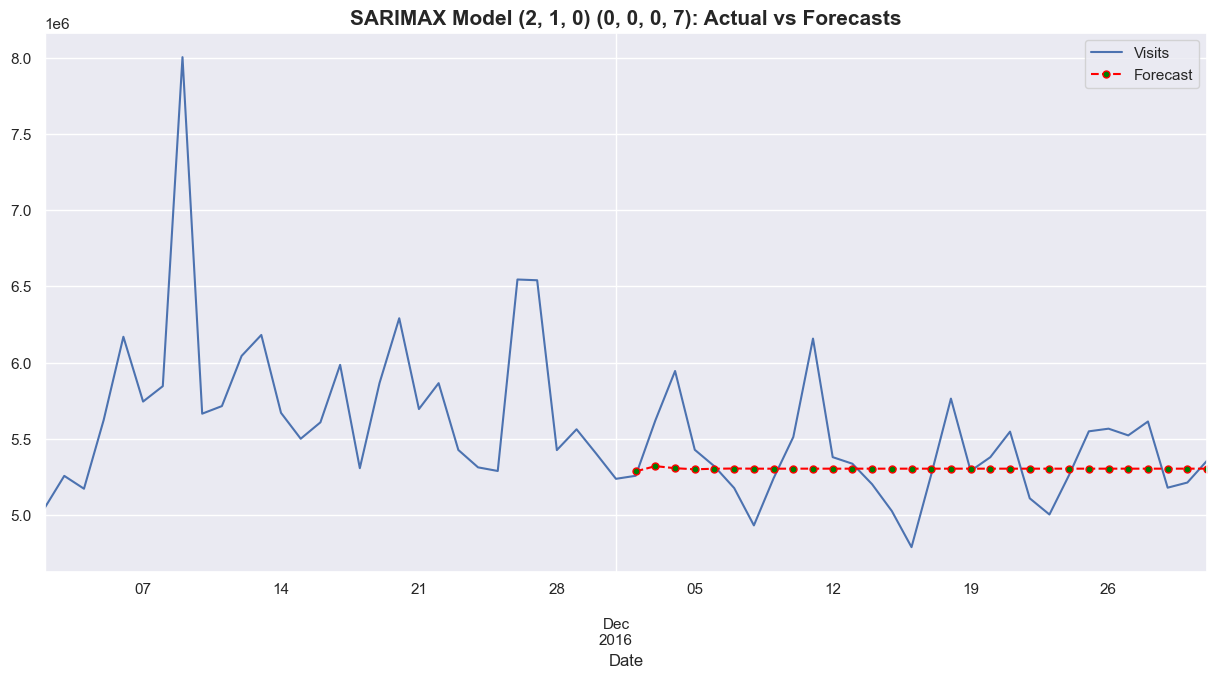


------------------------------------------------------------------------------------------
SARIMAX model for French Time Series
Parameters of Model: (0, 1, 2) (0, 0, 0, 7)
MAPE of Model: 0.08091
RMSE of Model: 1489350.009
------------------------------------------------------------------------------------------


<Figure size 2000x800 with 0 Axes>

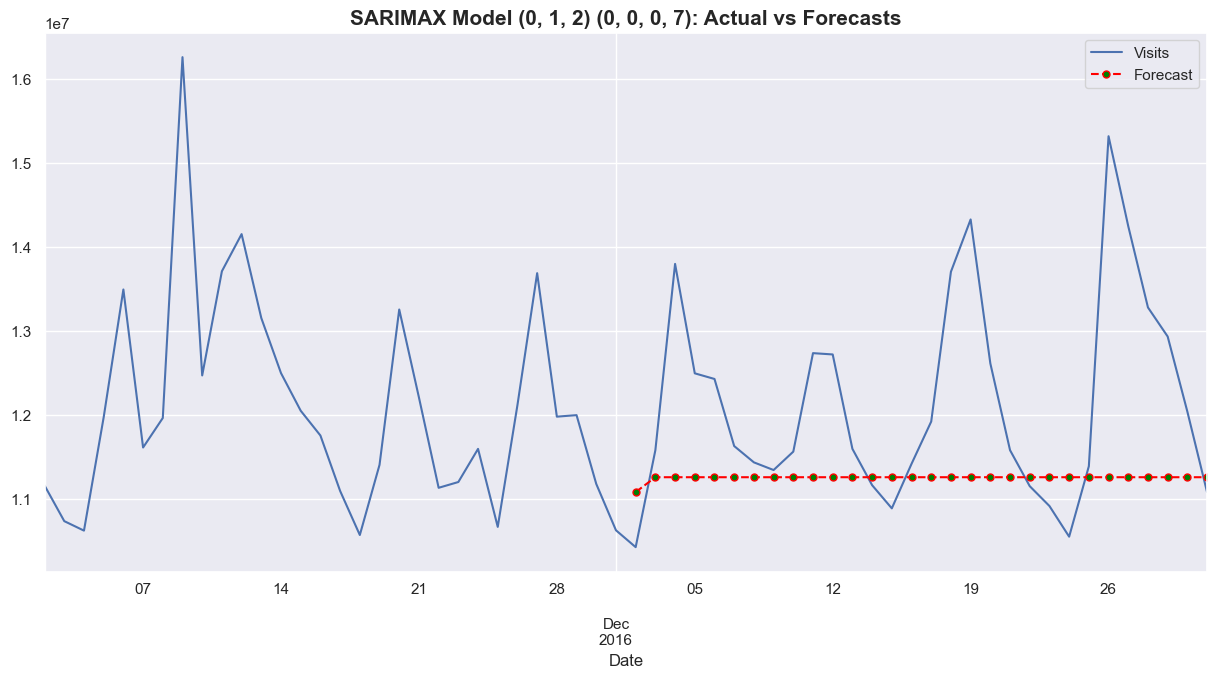


------------------------------------------------------------------------------------------
SARIMAX model for German Time Series
Parameters of Model: (2, 0, 1) (0, 0, 0, 7)
MAPE of Model: 0.08384
RMSE of Model: 2195114.679
------------------------------------------------------------------------------------------


<Figure size 2000x800 with 0 Axes>

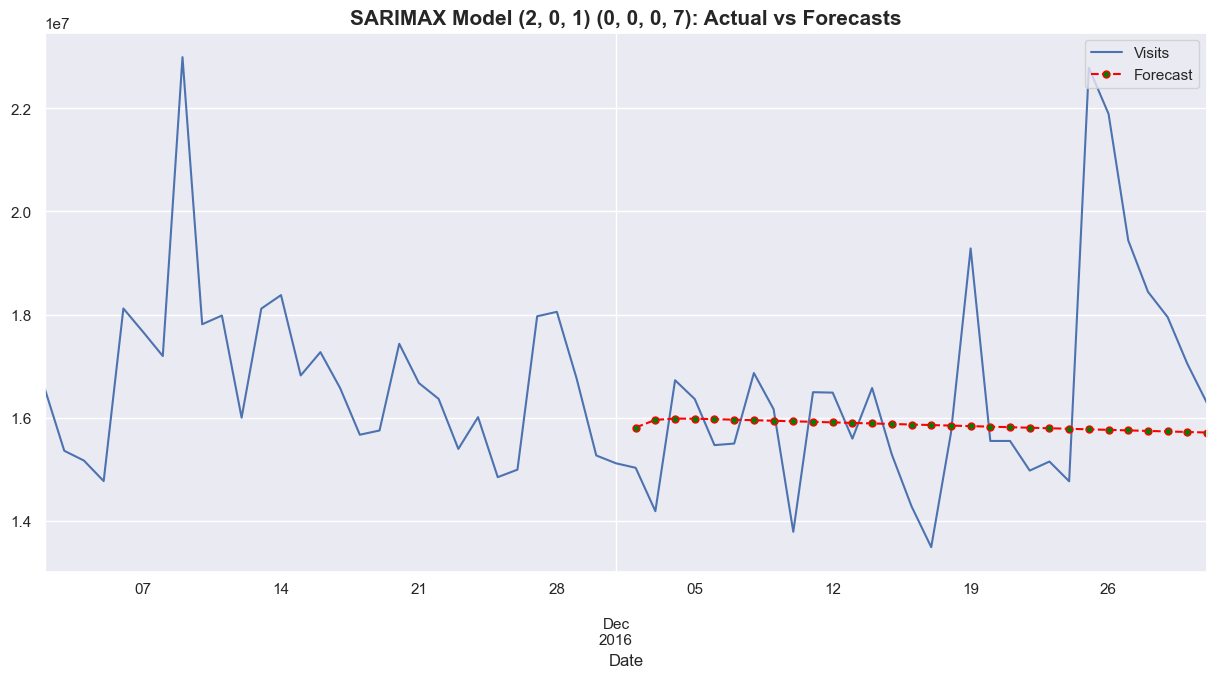


------------------------------------------------------------------------------------------
SARIMAX model for Japenese Time Series
Parameters of Model: (1, 1, 2) (0, 0, 1, 7)
MAPE of Model: 0.0934
RMSE of Model: 2400870.834
------------------------------------------------------------------------------------------


<Figure size 2000x800 with 0 Axes>

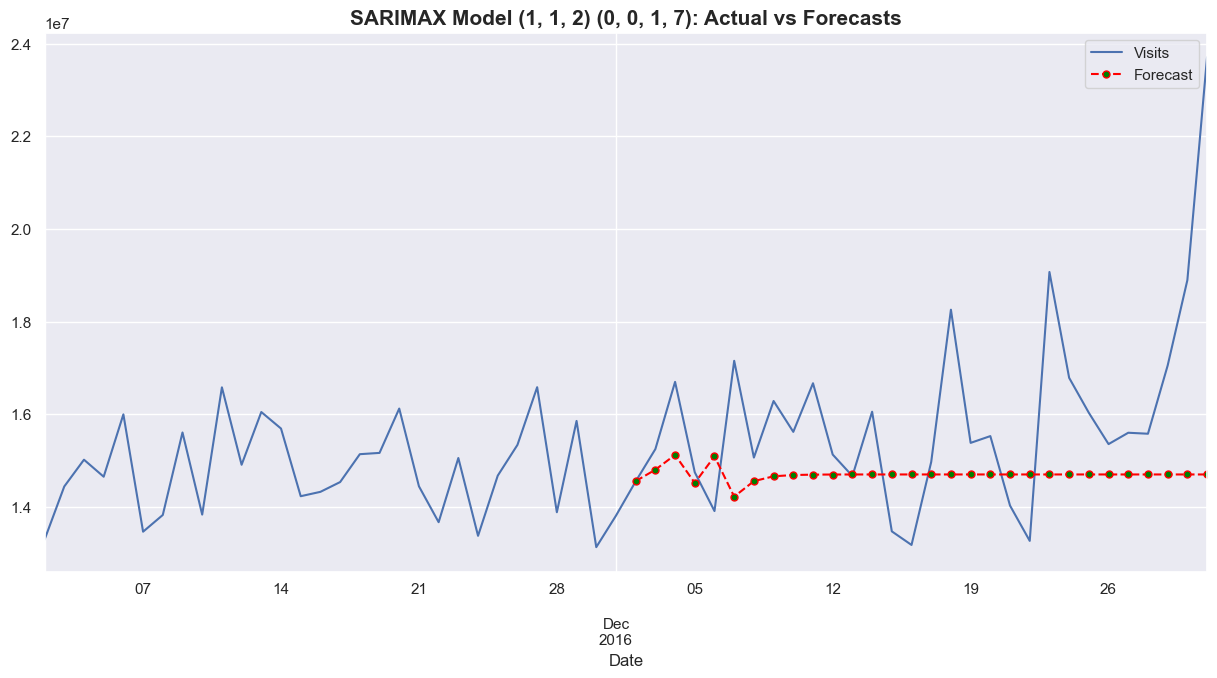


------------------------------------------------------------------------------------------
SARIMAX model for Russian Time Series
Parameters of Model: (0, 0, 1) (2, 0, 0, 7)
MAPE of Model: 0.06795
RMSE of Model: 1206324.353
------------------------------------------------------------------------------------------


<Figure size 2000x800 with 0 Axes>

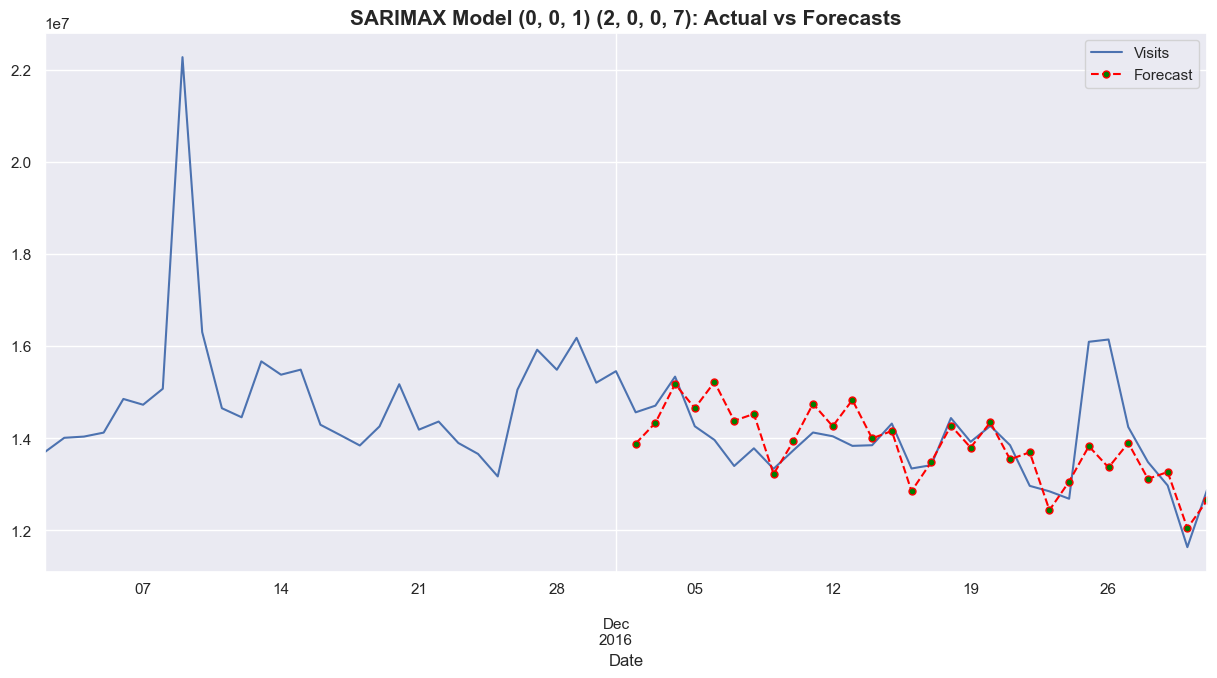


------------------------------------------------------------------------------------------
SARIMAX model for Spanish Time Series
Parameters of Model: (2, 0, 0) (0, 0, 1, 7)
MAPE of Model: 0.14351
RMSE of Model: 2344695.867
------------------------------------------------------------------------------------------


<Figure size 2000x800 with 0 Axes>

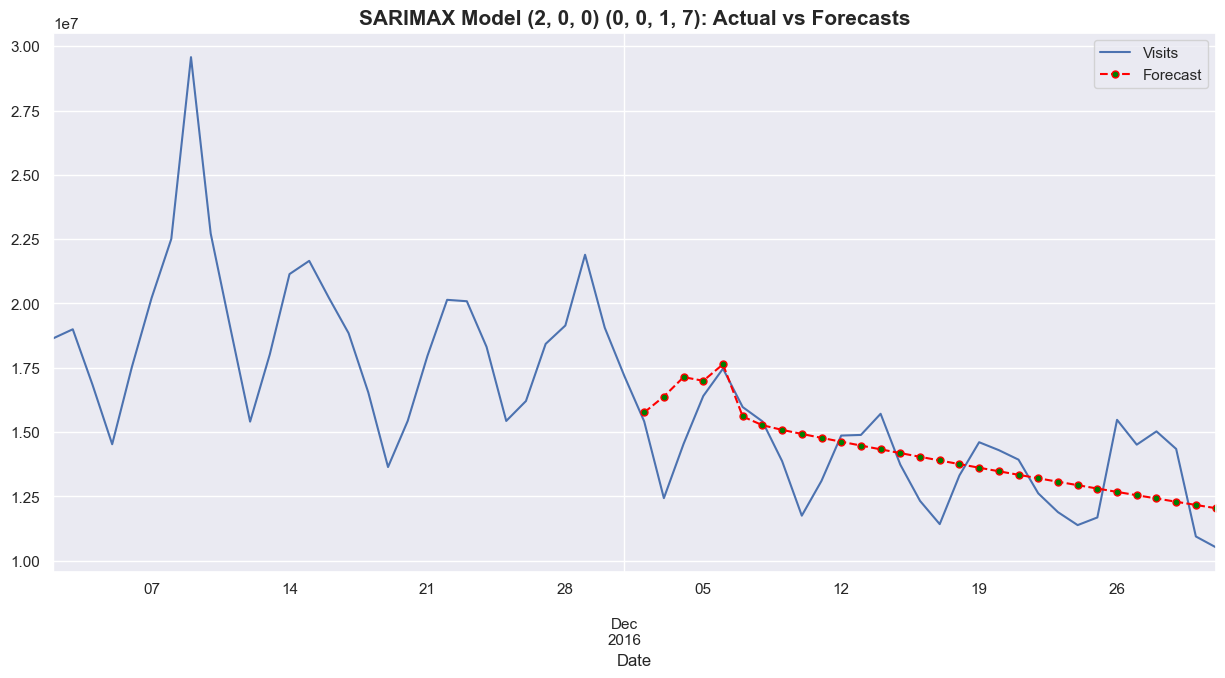

0

In [52]:
languages = ['Chinese', 'French', 'German', 'Japenese', 'Russian', 'Spanish']
n = 30 
plot_best_SARIMAX_model(languages, lang_data, n, best_param_df)

In [64]:
time_series = lang_data[lang_data['language'] == 'English'][['Date', 'Visits']]
# time_series.set_index('Date', drop=True, inplace=True)
time_series.columns = ['ds', 'y']
time_series['exog'] = exog

17:53:03 - cmdstanpy - INFO - Chain [1] start processing
17:53:03 - cmdstanpy - INFO - Chain [1] done processing


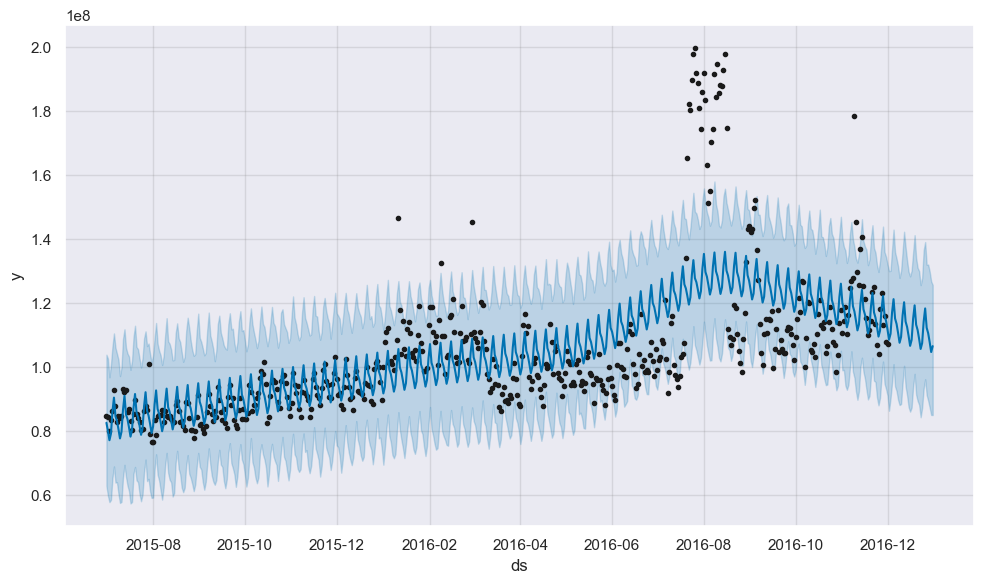

In [65]:
prophet1 = Prophet(weekly_seasonality=True)
prophet1.fit(time_series[['ds', 'y']][:-30])
future = prophet1.make_future_dataframe(periods=30, freq= 'D')
forecast = prophet1.predict(future)
fig1 = prophet1.plot(forecast)


17:53:18 - cmdstanpy - INFO - Chain [1] start processing
17:53:18 - cmdstanpy - INFO - Chain [1] done processing


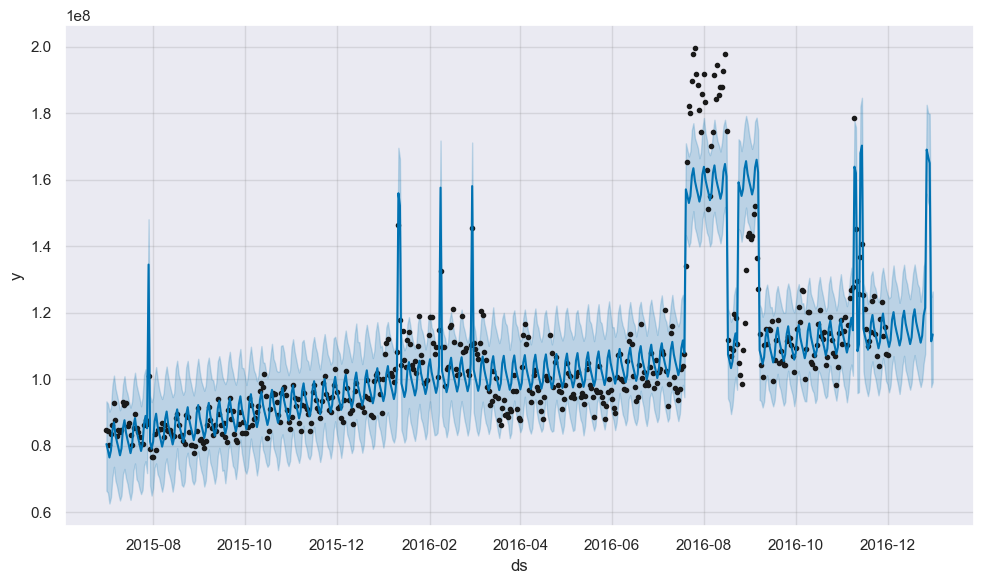

In [66]:
prophet2 = Prophet(weekly_seasonality=True)
prophet2.add_regressor('exog')
prophet2.fit(time_series[:-30])
#future2 = prophet2.make_future_dataframe(periods=30, freq= 'D')
forecast2 = prophet2.predict(time_series)
fig2 = prophet2.plot(forecast2)

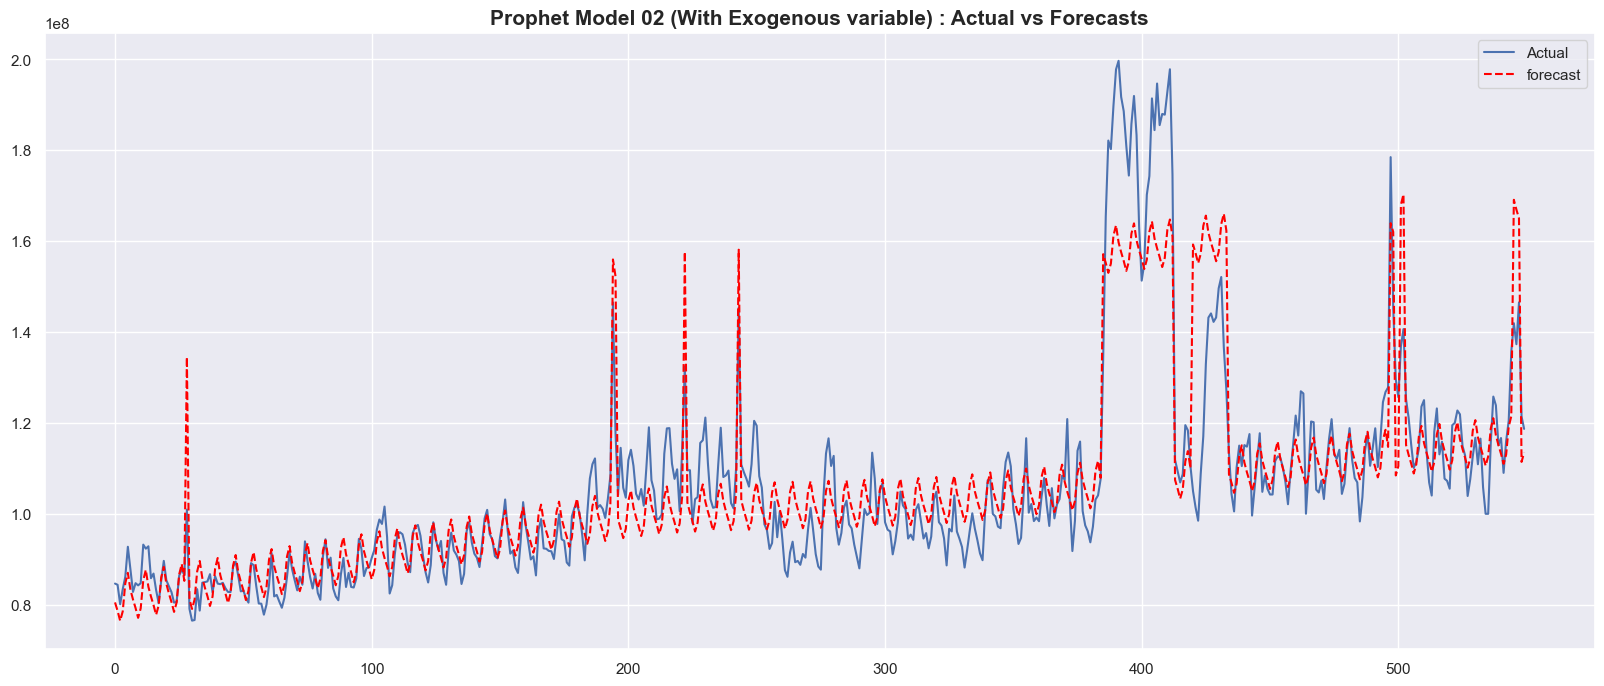

In [67]:
actual = time_series['y'].values
forecast = forecast2['yhat'].values

plt.figure(figsize = (20,8))
plt.plot(actual, label = 'Actual')
plt.plot(forecast, label = 'forecast', color = 'red', linestyle='dashed')
plt.legend(loc="upper right")
plt.title(f'Prophet Model 02 (With Exogenous variable) : Actual vs Forecasts', fontsize = 15, fontweight = 'bold')
plt.show()


In [68]:
errors = abs(actual - forecast)
mape = np.mean(errors/abs(actual))
mape

0.05984297528112341

> FB Prophet Model is able to capture peaks because of exogenous variable and is giving a MAPE of 6%

### Recommendations

1. Prioritize English language pages due to their low MAPE and high mean visits, making them optimal for advertising efforts to maximize reach and effectiveness.
  
2. Avoid advertising on Chinese language pages unless there's a specific marketing strategy tailored for Chinese populations, as they have the lowest number of visits.
  
3. Russian language pages present a promising opportunity for high conversion rates with their decent number of visits and low MAPE if utilized effectively.
  
4. Despite having the second-highest number of visits, Spanish language pages exhibit the highest MAPE, suggesting that advertisements on these pages may not effectively reach the intended audience.
  
5. French, German, and Japanese language pages show moderate levels of visits and MAPE. Depending on the target customers, consider advertising campaigns on these pages to capitalize on their potential reach and conversion rates.

### Questionnaire

1. Defining the problem statements and where can this and modifications of this be used?
> Identification of the problem and its applications:
   - The Data Science team at Ad ease aims to analyze per page view reports for various Wikipedia pages spanning 550 days. 
   - The objective includes forecasting page views to enhance ad placement optimization for clients.
   - Dataset encompasses 145k Wikipedia pages with daily view counts.
   - Client base extends across diverse regions, necessitating insights into ad performance across different languages.

> Importance of forecasting model:
   - Implementing a robust forecasting model is pivotal in predicting fluctuations in page visits.
   - This model aids the business team in optimizing marketing expenditure.
   - Precise prediction of high-traffic days enables strategic ad placement, maximizing audience reach while optimizing spending.



2. Write 3 inferences you made from the data visualizations.
> Inferences from Data Visualizations:
   - Linguistic Diversity: The data reveals the presence of 7 languages, with English dominating, followed by Japanese, German, and French.
   - Access Type Distribution: Three access types are identified—All-access, mobile-web, and desktop—comprising 51.4%, 24.9%, and 23.6% respectively.
   - Access-Origin Insights: The dataset illustrates two access origins—'all-agents' and 'spider'—with 'all-agents' constituting 75.8% and 'spider' 24.2% of the data.

> Advertising Strategies:
   - English Language Dominance: English emerges as the most prominent language, suggesting prioritized advertisement placement due to its low Mean Absolute Percentage Error (MAPE) and high mean visit count.
   - Chinese Language Considerations: Pages in Chinese exhibit the lowest visit counts, signaling caution in advertisement allocation unless specifically targeting Chinese demographics.
   - Russian Language Potential: Russian language pages demonstrate a favorable balance between visit count and MAPE, indicating potential for maximum conversion if utilized effectively.
   - Spanish Language Challenges: Despite being the second-highest in visit count, Spanish pages exhibit the highest MAPE, suggesting potential challenges in advertisement efficacy.
   - Moderate Performers: French, German, and Japanese languages present medium-level visit counts and MAPE levels, prompting tailored advertisement strategies based on target customer demographics.

## Time Series Decomposition
3. What does the decomposition of series do?
Time series decomposition is a statistical technique used to break down a time series into its constituent components in order to understand its underlying structure, trends, seasonality, and irregular fluctuations. The decomposition typically involves separating the time series data into three main components:

1. **Trend (\(T_t\)):** The long-term movement or pattern in the data, representing the overall direction in which the time series is moving.
2. **Seasonality (\(S_t\)):** The repeating patterns or fluctuations that occur at regular intervals within the time series data.
3. **Residuals (\(R_t\)):** The remaining variation in the data after removing the trend and seasonality components.

The time series \(y_t\) can be decomposed into its components as follows:

- **Additive Decomposition:**
  \[ y_t = T_t + S_t + R_t \]

- **Multiplicative Decomposition:**
  \[ y_t = T_t \times S_t \times R_t \]

Various techniques such as moving averages, exponential smoothing, or mathematical models can be used to estimate the trend and seasonal components, leaving the residual component as the leftover variation in the data.



4. What level of differencing gave you a stationary series?

First order differencing

5. Difference between arima, sarima & sarimax.

> **ARIMA (Autoregressive Integrated Moving Average):**
   - ARIMA is a time series forecasting model that combines autoregression (AR), differencing (I), and moving average (MA) components.
   - It's suitable for univariate time series data without exogenous variables.
   - ARIMA(p,d,q) where p represents the autoregressive order, d represents the differencing order, and q represents the moving average order.

> **SARIMA (Seasonal Autoregressive Integrated Moving Average):**
   - SARIMA is an extension of ARIMA that incorporates seasonal components in addition to the non-seasonal ones.
   - It's suitable for time series data with seasonal patterns.
   - SARIMA(p,d,q)(P,D,Q)m where P, D, and Q represent the seasonal autoregressive, differencing, and moving average orders respectively, and 'm' represents the seasonal period.

> **SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Variables):**
   - SARIMAX extends SARIMA by allowing the inclusion of exogenous variables, which are external factors that can influence the time series.
   - It's suitable for time series data with both seasonal patterns and external variables.
   - SARIMAX(p,d,q)(P,D,Q)m with exogenous variables.

These models are commonly used in time series analysis and forecasting tasks, each offering different capabilities to handle various types of data and patterns.

6. Compare the number of views in different languages

In [78]:
grouped = reshaped.groupby(['language','access_type','access_origin'], as_index=False)['Visits'].sum()

<Axes: xlabel='language', ylabel='Visits'>

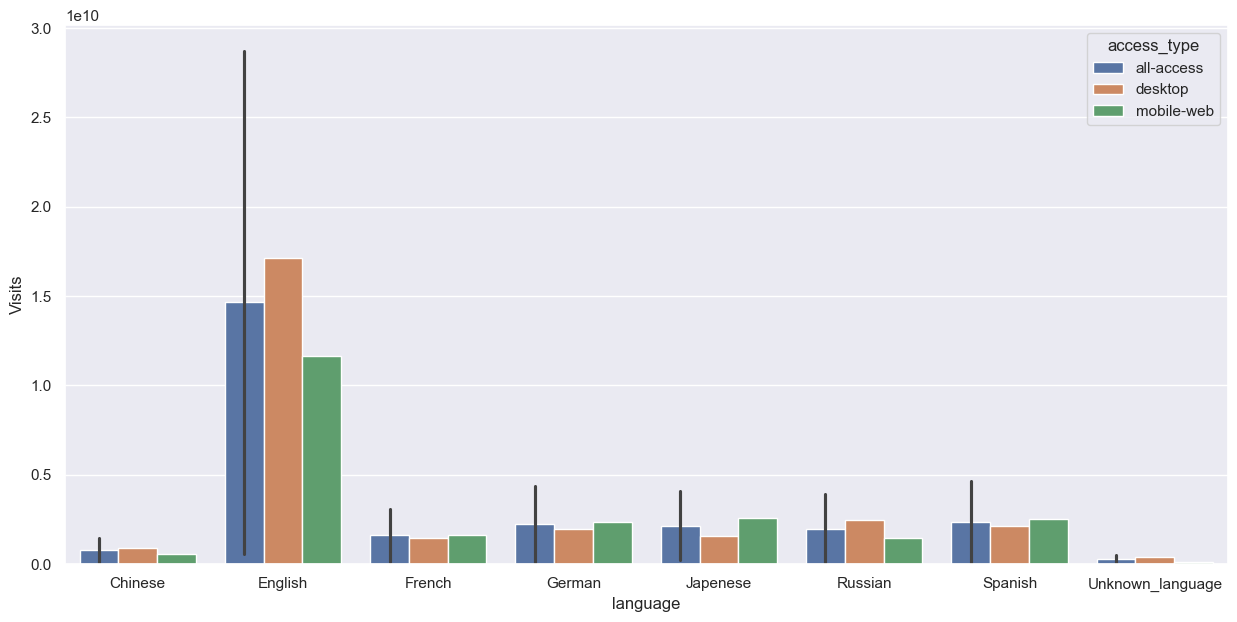

In [87]:
sns.barplot(grouped, x="language", y="Visits", hue="access_type")

7. What other methods other than grid search would be suitable to get the model for all languages?

- We can use packages like hyperopt, optuna and sci-kit-optimize
- We can try and use different models like tsmixer and deep learning models